In [5]:
!pip install optunahub cmaes torch scipy

In [6]:
!pip install optuna

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import os
import textwrap

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

from scipy.stats import uniform
import optuna
import optunahub

In [8]:
# TODOs

# Normalization
# Random state?
# Try ngrams
# Eliminate validation set split
# Update graph to include all folds
# Embeddings

# X Do more preprocessing? (reintroduce stripping characters, stem words, etc.)
# X Try hyperparameter grid search first then follow with random?
# X Elastic net l1 penatly?
# X Fit transform/how do we get the vocabulary out of the fit?
# X Swap AUCROC to accuracy and see what happens

# X Create a sklearn pipeline
  ## X CountVectorizer step (with preprocessing)
    ### X Set up pre-processor: what characters to get rid of, lowercase, etc.
    ### X Hyperparameter selection (min_df, max_df, binary vs. count, max_features)
  ## X LogisticRegression step
    ### X Hyperparameter selection (C, l1_ratio, max_iter)

# X Cross validation
  ## X Random search (pick a range for each)
  ## X 10-fold

# Metrics
  ## AUCROC (instead of accuracy) - report average, stdev across folds


In [3]:
# Clone repo
!rm -rf /content/text-classifier  # clear any existing clone
!git clone "https://github.com/rowanmacy/text-classifier/"  # clone repo

Cloning into 'text-classifier'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 51 (delta 12), reused 15 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 31.27 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [9]:
# Check repo contents
!ls /content/text-classifier/starter_code/data_readinglevel/

x_test_BERT_embeddings.npz  x_train_BERT_embeddings.npz  y_train.csv
x_test.csv		    x_train.csv


## Read in data

In [35]:
# Read in training data
x_train_df = pd.read_csv("/content/text-classifier/starter_code/data_readinglevel/x_train.csv")
y_train_df = pd.read_csv("/content/text-classifier/starter_code/data_readinglevel/y_train.csv")
x_test_df = pd.read_csv("/content/text-classifier/starter_code/data_readinglevel/x_test.csv")

In [36]:
# Generate groups of unique combinations of author and title for grouping of CV splits later
author_title_combos = x_train_df[['author', 'title']].drop_duplicates()
author_title_combos['group'] = range(0, len(author_title_combos))

x_train_groupings = pd.merge(x_train_df, author_title_combos, on=['author', 'title'], how='left')

# Extract groups
groups = x_train_groupings['group'].values.tolist()

In [37]:
# Extract text information from x_train_df and x_test_df
tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

In [38]:
# Convert y_train_df into binary classification array
# Turn y_train data into binary classification
y_train_df['Class'] = (y_train_df['Coarse Label'] == 'Key Stage 4-5').astype(int)
y_train = np.asarray(y_train_df['Class'])

## Pre-defined split for proxy test set (validation)

In [39]:
# Separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(tr_text_list, y_train, test_size=0.2, random_state=42, shuffle=True)
X_train_groups = groups[:len(X_train)]
X_val_groups = groups[len(X_train):]

## Set up pipeline

In [40]:
# Define pipeline for preprocessing and classifier
problem_1_pipeline = Pipeline([
    ('problem_1_preprocessor', CountVectorizer(lowercase=True, strip_accents='ascii')),
     ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, penalty='l2')),
])

In [41]:
# Define total possible vocabulary
vocab_vectorizer = CountVectorizer(lowercase=True, strip_accents='ascii')
vocab_vectorizer.fit(tr_text_list)
max_features_total = len(vocab_vectorizer.vocabulary_)
print(max_features_total)

27674


## Set up Optuna

In [51]:
# Set up objective function
def objective(trial):
  # Suggest vectorizer
  #vectorizer = trial.suggest_categorical('vectorizer', ['CountVectorizer', 'TfidfVectorizer'])

  # Suggest model
  # model = trial.suggest_categorical('classifier', ['LogisticRegression', 'SVM', ])

  # Suggest values for the hyperparameters
  C = trial.suggest_float('C', 10e-6, 10e2, log=True)
  min_df = trial.suggest_float('min_df', 0.01, 0.04)
  max_df = trial.suggest_float('max_df', 0.6, 1.0)
  max_features = trial.suggest_int('max_features', int(0.6 * max_features_total), int(0.8 * max_features_total))
  #penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

  # Create classifier
  # if vectorizer == 'CountVectorizer':
  #   model = Pipeline([
  #     ('problem_1_preprocessor', CountVectorizer(lowercase=True, strip_accents='ascii', max_df=max_df, min_df=min_df, max_features=max_features)),
  #     ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, C=C, solver='lbfgs'))])

  # else:
  model = Pipeline([
      ('problem_1_preprocessor', TfidfVectorizer(lowercase=True, strip_accents='ascii', max_df=max_df, min_df=min_df, max_features=max_features)),
      ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, C=C, solver='lbfgs'))])


  # Perform 5-fold cross-validation and calculate AUROC
  score = cross_val_score(model, X_train, y_train, cv=GroupKFold(n_splits=10, shuffle=True).get_n_splits(groups=groups), scoring='roc_auc').mean()

  return score

In [52]:
# Load autosampler
module = optunahub.load_module(package="samplers/auto_sampler")

In [53]:
# Create and run study
study = optuna.create_study(direction='maximize', sampler=module.AutoSampler())
study.optimize(objective, n_trials=100)

[I 2026-02-25 17:00:10,002] A new study created in memory with name: no-name-ce51aa17-4f4d-43fd-928e-6c47bb455cd8
[I 2026-02-25 17:00:18,619] Trial 0 finished with value: 0.7092715435169831 and parameters: {'C': 0.00043966751001911513, 'min_df': 0.03351981021998846, 'max_df': 0.7303640464619241, 'max_features': 21578}. Best is trial 0 with value: 0.7092715435169831.
/root/.cache/optunahub/github.com/optuna/optunahub-registry/main/package/samplers/auto_sampler/_sampler.py:229: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  return GPSampler(seed=seed, constraints_func=self._constraints_func)
[I 2026-02-25 17:00:23,129] Trial 1 finished with value: 0.717749611250232 and parameters: {'C': 11.076249137690962, 'min_df': 0.024496663463193506, 'max_df': 0.6773486587464066, 'max_features': 18014}. Best is trial 1 with value: 0.717749611250232.
[I 2026-02-25 17:00:28,484] Trial 2 finished with value: 0.7124926873424821 and parame

In [54]:
# Extract parameters from best trial
trial = study.best_trial
hyperparameters = trial.params

for param, value in hyperparameters.items():
  print(f'{param}:', value)

print('\nBest score:', round(study.best_value,3))

C: 0.4045472960803594
min_df: 0.01
max_df: 1.0
max_features: 20666

Best score: 0.739


In [55]:
# Train model with best performing hyperparameters
model = Pipeline([
    ('problem_1_preprocessor', CountVectorizer(lowercase=True, strip_accents='ascii', max_df=hyperparameters['max_df'], min_df=hyperparameters['min_df'], max_features=hyperparameters['max_features'])),
     ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, penalty='l2', C=hyperparameters['C'])),
  ])

model.fit(X_train, y_train)


Pipeline(steps=[('problem_1_preprocessor',
                 CountVectorizer(max_features=20666, min_df=0.01,
                                 strip_accents='ascii')),
                ('problem_1_model',
                 LogisticRegression(C=0.4045472960803594, max_iter=500,
                                    random_state=101))])

In [56]:
# Evaluate performance on training and validation data
yhat_tr = model.predict_proba(X_train)[:,1]
yhat_val = model.predict_proba(X_val)[:,1]

# Calculate AUROC for training and validation predictions
roc_auc_tr = roc_auc_score(y_train, yhat_tr)
roc_auc_val = roc_auc_score(y_val, yhat_val)
print('Training score:', round(roc_auc_tr, 3))
print('Validation score:', round(roc_auc_val, 3))

Training score: 0.838
Validation score: 0.716


## Create RandomizedSearchCV

In [23]:
# Define hyperparameter grid to search and scoring metric
distributions = dict()

# Preprocessing hyperparameters
distributions['problem_1_preprocessor__min_df'] = np.linspace(0.01, 0.04, 100)
distributions['problem_1_preprocessor__max_df'] = np.linspace(0.6, 1.0, 100)
distributions['problem_1_preprocessor__max_features'] = np.linspace(int(0.6 * max_features_total), int(0.8 * max_features_total), 100).astype(np.int_)
#distributions['problem_1_preprocessor__binary'] = [False, True]

# Model parameters
distributions['problem_1_model__C'] = np.logspace(-6, 6, 1000)
#distributions['problem_1_model__l1_ratio'] = np.linspace(0, 1, 5)

scoring_metric = 'roc_auc'

In [24]:
# Define RandomizedSearchCV and fit to training data
random_searcher = RandomizedSearchCV(
    problem_1_pipeline,
    distributions,
    n_iter=100,  # increases number of parameter combinations tried
    scoring=scoring_metric,
    cv=GroupKFold(n_splits=10, shuffle=False).get_n_splits(groups=X_train_groups), # Always good to shuffle
    refit=True, # Automatically retrain the best-performing model on all available data
    verbose = 2,
    # random_state=101,
    error_score = 'raise')

In [25]:
# Fit random_searcher object to training data
random_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END problem_1_model__C=1.0280447320933098e-06, problem_1_preprocessor__max_df=0.6484848484848484, problem_1_preprocessor__max_features=19287, problem_1_preprocessor__min_df=0.028484848484848488; total time=   0.4s
[CV] END problem_1_model__C=1.0280447320933098e-06, problem_1_preprocessor__max_df=0.6484848484848484, problem_1_preprocessor__max_features=19287, problem_1_preprocessor__min_df=0.028484848484848488; total time=   0.4s
[CV] END problem_1_model__C=1.0280447320933098e-06, problem_1_preprocessor__max_df=0.6484848484848484, problem_1_preprocessor__max_features=19287, problem_1_preprocessor__min_df=0.028484848484848488; total time=   0.4s
[CV] END problem_1_model__C=1.0280447320933098e-06, problem_1_preprocessor__max_df=0.6484848484848484, problem_1_preprocessor__max_features=19287, problem_1_preprocessor__min_df=0.028484848484848488; total time=   0.4s
[CV] END problem_1_model__C=1.0280447320933098e-06, problem

RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('problem_1_preprocessor',
                                              CountVectorizer(strip_accents='ascii')),
                                             ('problem_1_model',
                                              LogisticRegression(max_iter=500,
                                                                 random_state=101))]),
                   n_iter=100,
                   param_distributions={'problem_1_model__C': array([1.00000000e-06, 1.02804473e-06, 1.05687597e-06, 1.08651577e-06,
       1.11698682e-06, 1.1483...
       0.03121212, 0.03151515, 0.03181818, 0.03212121, 0.03242424,
       0.03272727, 0.0330303 , 0.03333333, 0.03363636, 0.03393939,
       0.03424242, 0.03454545, 0.03484848, 0.03515152, 0.03545455,
       0.03575758, 0.03606061, 0.03636364, 0.03666667, 0.0369697 ,
       0.03727273, 0.03757576, 0.03787879, 0.03818182, 0.03848485,
       0.03878788, 0.03909091, 0.03939394, 0.03969697, 0.04      ])},
                   scoring='roc_auc', verbose=2)

In [26]:
# Print result of search
problem_1_hyp_results = pd.DataFrame(random_searcher.cv_results_).copy()
param_keys = ['param_'+str(key) for key in random_searcher.best_params_.keys()]

# Rearrange row order
problem_1_hyp_results.sort_values(param_keys, inplace=True)

# Visualize
problem_1_hyp_results[param_keys + ['mean_test_score', 'rank_test_score']]

,param_problem_1_preprocessor__min_df,param_problem_1_preprocessor__max_features,param_problem_1_preprocessor__max_df,param_problem_1_model__C,mean_test_score,rank_test_score
68,0.010303,19958,0.967677,412682.084570,0.646695,100
74,0.010606,16995,0.664646,0.001525,0.711676,5
45,0.010606,17945,0.923232,0.039866,0.700589,21
22,0.011212,22139,0.955556,136500.780655,0.661148,99
46,0.011515,20629,0.923232,0.000176,0.693274,35
...,...,...,...,...,...,...
98,0.039394,19679,0.608081,0.045778,0.698867,23
17,0.039394,21356,0.959596,0.079598,0.698526,25
11,0.040000,20014,0.721212,3447.764055,0.690226,48
4,0.040000,21188,0.907071,54794.723369,0.692022,42


In [27]:
# Capture best hyperparameters
problem_1_params = random_searcher.best_params_

for param, value in problem_1_params.items():
  print(param, ':', value)

problem_1_preprocessor__min_df : 0.01606060606060606
problem_1_preprocessor__max_features : 17330
problem_1_preprocessor__max_df : 0.8505050505050504
problem_1_model__C : 0.0032174181506763717


## Make predictions and plot ROC curve

In [28]:
# Evaluate performance on training and validation data
yhat_tr = random_searcher.predict_proba(X_train)[:,1]
yhat_val = random_searcher.predict_proba(X_val)[:,1]

# Calculate AUROC for training and validation predictions
roc_auc_tr = roc_auc_score(y_train, yhat_tr)
roc_auc_val = roc_auc_score(y_val, yhat_val)
print('Training score:', round(roc_auc_tr, 3))
print('Validation score:', round(roc_auc_val, 3))

Training score: 0.763
Validation score: 0.697


In [29]:
# Print confusion matrices at 50% threshold
print('Training CF:\n', confusion_matrix(y_train, yhat_tr >= 0.5))
print('\nValidation CF:\n', confusion_matrix(y_val, yhat_val >= 0.5))

Training CF:
 [[1267  820]
 [ 536 1822]]

Validation CF:
 [[229 193]
 [181 509]]


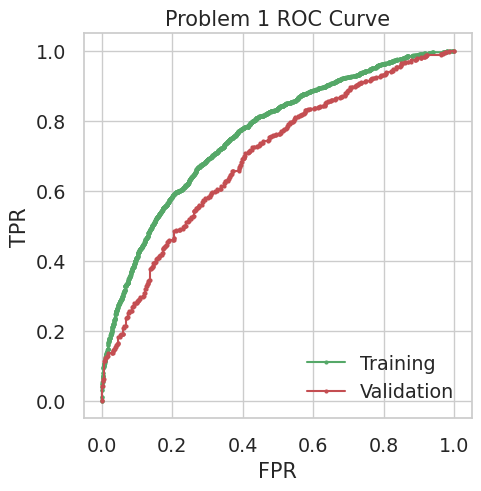

In [30]:
# Print ROC curves
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train, yhat_tr)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, yhat_val)

plt.figure(figsize=(5,5))
plt.plot(tr_fpr, tr_tpr, 'g.-', label='Training')
plt.plot(val_fpr, val_tpr, 'r.-', label='Validation')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Problem 1 ROC Curve')
plt.legend(loc='lower right')

## Create graphic for hyperparameter selection of 'min_df'

In [31]:
# Generate range of values for min_df and initialize AUROC score lists
min_df_range = np.linspace(0, 0.04, 20)
#C_range = np.logspace(-6, 3, 20)
tr_AUROC = []
val_AUROC = []

In [32]:
# Loop through values of min_df and calculate training and validation scores
for frac in min_df_range:
  problem_1_hyp_pipeline = Pipeline([
    ('problem_1_preprocessor', CountVectorizer(lowercase=True, strip_accents='ascii', max_df=problem_1_params['problem_1_preprocessor__max_df'], max_features=problem_1_params['problem_1_preprocessor__max_features'], min_df=frac)),
    ('problem_1_model', LogisticRegression(max_iter=500, random_state=101, penalty='l2', C=problem_1_params['problem_1_model__C']))])

  # Fit to training data
  problem_1_hyp_pipeline.fit(X_train, y_train)

  # Predict on training and validation sets
  yhat_tr = problem_1_hyp_pipeline.predict_proba(X_train)[:,1]
  yhat_val = problem_1_hyp_pipeline.predict_proba(X_val)[:,1]

  # Calculate and append AUROC scores
  tr_AUROC.append(roc_auc_score(y_train, yhat_tr))
  val_AUROC.append(roc_auc_score(y_val, yhat_val))

  print(frac, ':', roc_auc_score(y_val, yhat_val))


0.0 : 0.7016278590562539
0.002105263157894737 : 0.7007383748883852
0.004210526315789474 : 0.6994985919362593
0.00631578947368421 : 0.6984614327907137
0.008421052631578947 : 0.6977230579023284
0.010526315789473684 : 0.6973109416855552
0.01263157894736842 : 0.6976165945463286
0.014736842105263158 : 0.6968301394326533
0.016842105263157894 : 0.6968335737344598
0.01894736842105263 : 0.6954220756920119
0.021052631578947368 : 0.6955354076516244
0.023157894736842106 : 0.695487327426334
0.02526315789473684 : 0.6958067174943334
0.027368421052631577 : 0.6954873274263342
0.029473684210526315 : 0.6933374544955011
0.031578947368421054 : 0.6906415275774433
0.03368421052631579 : 0.689164777800673
0.035789473684210524 : 0.6883405453671269
0.03789473684210526 : 0.687248437392678
0.04 : 0.6873823751631294


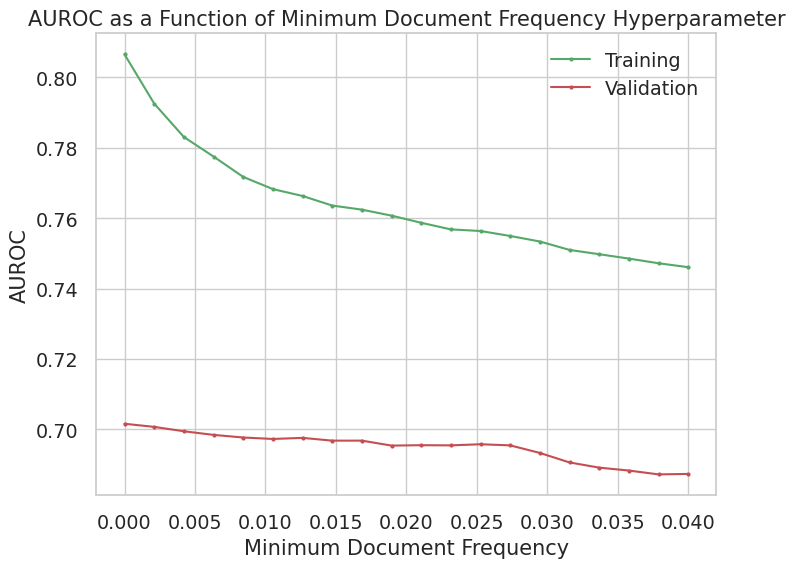

In [33]:
# Plot training and validation AUROC vs. value of min_df
plt.figure(figsize=(8,6))
plt.plot(min_df_range, tr_AUROC, 'g.-', label='Training')
plt.plot(min_df_range, val_AUROC, 'r.-', label='Validation')
plt.xlabel('Minimum Document Frequency')
plt.ylabel('AUROC')
plt.title('AUROC as a Function of Minimum Document Frequency Hyperparameter')
plt.legend()

## Save results to files

In [174]:
#file = open('parameter_iterations.txt', 'x')

In [175]:
# Save parameters to text file
with open('parameter_iterations.txt', "a") as f:
  for param, value in problem_1_params.items():
    f.write('\n' + str(param) + ': ' + str(value))
  f.write('\n\nTraining score: ' + str(round(roc_auc_tr, 3)))
  f.write('\n\n')

In [176]:
# Make predictions on test data
yhat_te = random_searcher.predict_proba(te_text_list)[:,1]

In [177]:
# Delete previous file
os.remove('yproba1_test.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'yproba1_test.txt'

In [ ]:
# Save results to .txt file
file = open('yproba1_test.txt', "x")

with open('yproba1_test.txt', "w") as f:
    f.write('\n'.join(yhat_te.astype('str')))

## ARCHIVE

In [ ]:
# Create CountVectorizer object
# TODO: min_df, max_df, binary
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(tr_text_list)
vectorizer.get_feature_names_out()
vocab_list = vectorizer.vocabulary_

In [ ]:
# Fit logistic regression model to training data
clf.fit(X_train, y_train)

In [ ]:
# Convert test data into vector
X_test_list = x_test_df['text'].values.tolist()
V = len(x_test_df)

In [ ]:
# Make predictions on test vector
yhat_test = []

for passage in X_test_list:
  x_V = vectorizer.transform([passage])
  #print(x_V.shape)
  prediction = clf.predict_proba(x_V.reshape((1,26866)))

  with open('yproba1_test.txt', 'a') as f:
    f.write(prediction[0][1].astype('str')+'\n')

  print('Prediction:', prediction[0][1])


In [ ]:
# Cross-validate
# Hyperparameter values
C_grid = np.logspace(-4, 4, 17)
k_grid = range(1, 18)

# Create development dataset

# Split data for CV
SEED = 12345

# Use K-fold to perform cross-validation
K = 10
kf = sklearn.model_selection.KFold(n_splits=K, shuffle=True, random_state=SEED)

# Train models with desired degree, alpha, K-fold
for c_ind, c in enumerate(C_grid):
        for k, (train_ind, val_ind) in enumerate(kf.split(X_train, y_train)):
            #print(f"fold {k}")
            model = sklearn.Pipeline([
                # TODO: call pipeline defined earlier
                ])
            #print(f"model defined")
            # Train the model
            model.fit(X_train[train_ind], y_train[train_ind])

            # Make predictions on validation data
            yhat_L = model.predict(X_train[val_ind])  #removed sanitize step since it's not defined in this notebook

            print(f"C {c}, K {k}, AUCROC")
            # TODO: compute AUCROC


In [ ]:
# Define preprocessor
def build_preprocessor():
  preprocessor = Pipeline([
      ('vectorizer', CountVectorizer(
       lowercase=True  # make everything lowercase
       #strip_accents='ascii',
       #stop_words='english'  # remove stop words
      ))
  ])
  return preprocessor

# Process data
preprocessor = build_preprocessor()
x_train_processed = preprocessor.fit_transform(x_train_df['text'])
max_features_total = x_train_processed.shape[1]